In [1]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
efficientnet = models.efficientnet_b0(pretrained=True).features
for param in efficientnet.parameters():
    param.requires_grad_(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 100MB/s]


Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [3]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

def imshow(tensor, title=None, ax=None, figsize=(5, 5)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    image = tensor.cpu().clone().detach().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

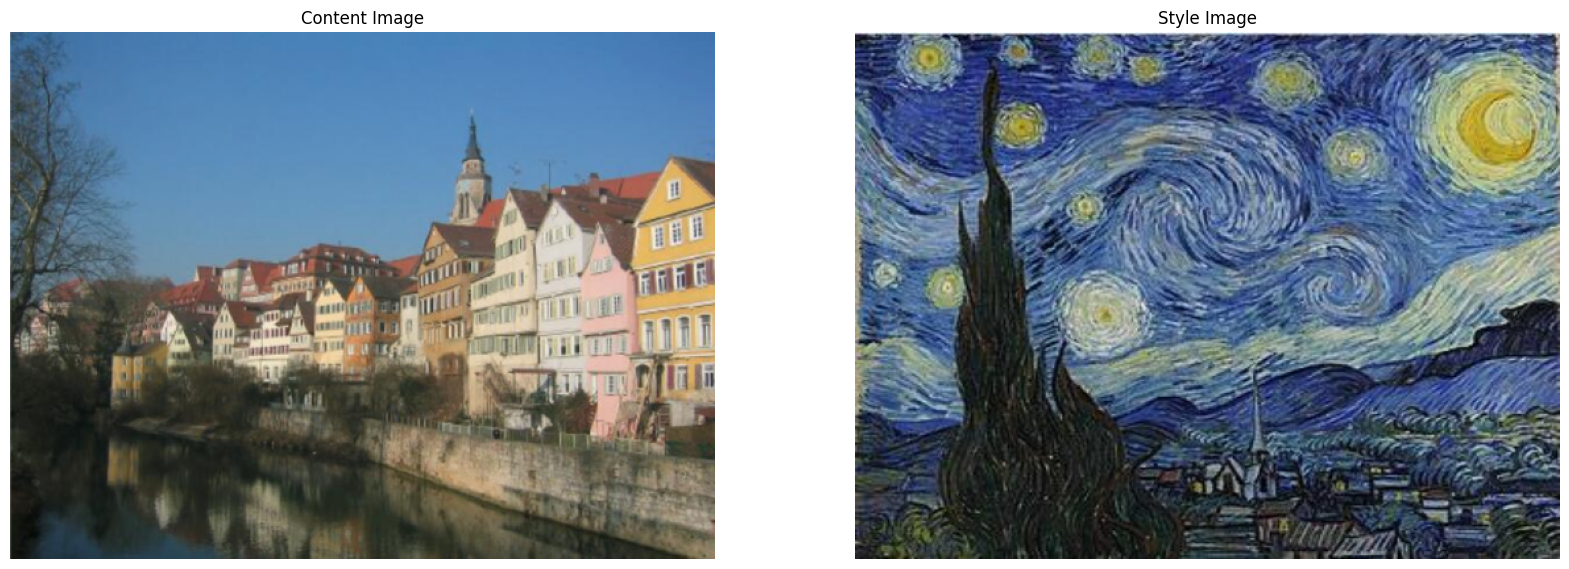

In [5]:
content_path = 'content2.jpg'
style_path = 'style2.jpg'

content_image = load_image(content_path).to(device)
style_image = load_image(style_path, shape=content_image.shape[-2:]).to(device)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
imshow(content_image, title='Content Image', ax=ax1)

imshow(style_image, title='Style Image', ax=ax2)

In [6]:
for idx, (name, layer) in enumerate(efficientnet.named_children()):
    print(name, layer)

0 Conv2dNormActivation(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)
1 Sequential(
  (0): MBConv(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): SqueezeExcitation(
        (avgpool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (activation): SiLU(inplace=True)
        (scale_activation): Sigmoid()
      )
      (2): Conv2dNormActivation(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0

In [14]:
def get_features(image, model, layers=None):
    """ Extracts the features from an image given the specified layers. """
    if layers is None:
        layers = {
            '0': 'style1',
            '1': 'style2',
            '2': 'style3',
            '3': 'style4',
            '4': 'content'
        }

    features = {}
    x = image
    # Iterate over the children; wrap the indices and layers with `enumerate` for access
    for name, layer in enumerate(model.children()):
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
            if len(features) == len(layers):
                break
    return features


In [16]:
# Function to calculate the Gram matrix of an image
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    return torch.mm(tensor, tensor.t())

# Loss functions
def content_loss(content_weight, target_features, content_features):
    return content_weight * torch.mean((target_features - content_features) ** 2)

def style_loss(style_weight, target_feature, style_gram):
    target_gram = gram_matrix(target_feature)
    return style_weight * torch.mean((target_gram - style_gram) ** 2)

# Performing the style transfer
def run_style_transfer(content_img, style_img, model, num_steps, style_weight=1e6, content_weight=1e5):
    """ Runs the style transfer. """
    target = content_img.clone().requires_grad_(True)
    optimizer = optim.Adam([target], lr=0.01)

    style_features = get_features(style_img, model)
    content_features = get_features(content_img, model)

    # Calculate the style Gram matrices for each layer
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features if 'style' in layer}

    for step in range(num_steps):
        target_features = get_features(target, model)

        # Calculate losses
        c_loss = content_loss(content_weight, target_features['content'], content_features['content'])
        s_loss = sum(style_loss(style_weight, target_features[layer], style_grams[layer]) for layer in style_grams)

        # Update target image
        optimizer.zero_grad()
        total_loss = c_loss + s_loss
        total_loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Step {step}, Total loss: {total_loss.item()}")

    return target

Step 0, Total loss: 7.86907844795433e+16
Step 100, Total loss: 1886665853370368.0
Step 200, Total loss: 791634279137280.0
Step 300, Total loss: 415602510397440.0
Step 400, Total loss: 239872077987840.0
Step 500, Total loss: 152394683908096.0
Step 600, Total loss: 107886793457664.0
Step 700, Total loss: 116076742443008.0
Step 800, Total loss: 79070901567488.0
Step 900, Total loss: 71974424412160.0
Step 1000, Total loss: 78135949262848.0
Step 1100, Total loss: 67531154915328.0
Step 1200, Total loss: 144987543044096.0
Step 1300, Total loss: 37043207929856.0
Step 1400, Total loss: 72361248292864.0


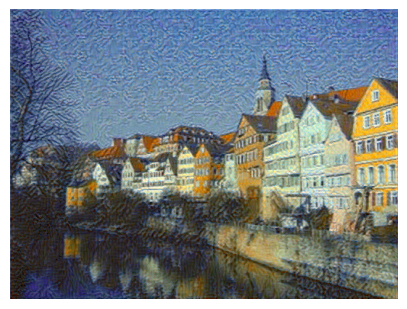

In [18]:
result = run_style_transfer(content_image, style_image, efficientnet, 1500)
imshow(result)